# YouTube8M EDA

The YouTube8M challenge is a multi-class classification problem, where we are asked to predict for each video, given video & frame level audio and frame RGB features, to which group of categories it belongs to.

For this task it is important to know:

* the total **number of classes/video categories**
* the **distribution of classes in the training set**

In the first part I'll be focusing on how to take apart detailed information about the labels for the training data. Especially taking into account frequent patterns that occur in the data. We will also be looking at co-dependencies of the most frequent label categories.

I've added a small section about the dependence of different video categories to the number of labels for each sample.


----------

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import seaborn as sns
from IPython.display import YouTubeVideo
import matplotlib.pyplot as plt

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))
print(check_output(["ls", "../input/video_level"]).decode("utf8"))

frame_level
label_names.csv
sample_submission.csv
video_level

train-0.tfrecord
train-1.tfrecord
train-2.tfrecord
train-3.tfrecord
train-4.tfrecord
train-5.tfrecord
train-6.tfrecord
train-7.tfrecord
train-8.tfrecord
train-9.tfrecord



### Read label names and count the distinct number of labels

In [2]:
labels_df = pd.read_csv('../input/label_names.csv')
filenames = ["../input/video_level/train-{}.tfrecord".format(i) for i in range(10)]
print("we have {} unique labels in the dataset".format(len(labels_df['label_name'].unique())))

we have 4630 unique labels in the dataset


### read labels for all training samples and map to textual representation

in `'../input/label_names.csv'` there are a few label ids missing

In [3]:
labels_df = pd.read_csv('../input/label_names.csv')
labels = []
textual_labels = []
textual_labels_nested = []
filenames = ["../input/video_level/train-{}.tfrecord".format(i) for i in range(10)]
total_sample_counter = 0

label_counts = []

for filename in filenames:
    for example in tf.python_io.tf_record_iterator(filename):
        total_sample_counter += 1
        tf_example = tf.train.Example.FromString(example)

        label_example = list(tf_example.features.feature['labels'].int64_list.value)
        label_counts.append(len(label_example))
        labels = labels + label_example
        label_example_textual = list(labels_df[labels_df['label_id'].isin(label_example)]['label_name'])
        textual_labels_nested.append(set(label_example_textual))
        textual_labels = textual_labels + label_example_textual
        if len(label_example_textual) != len(label_example):
            print('label names lookup failed: {} vs {}'.format(label_example, label_example_textual))

print('label ids missing from label_names.csv: {}'.format(sorted(set(labels) - set(labels_df['label_id']))))
print('Found {} samples in all of the 10 available tfrecords'.format(total_sample_counter))

label names lookup failed: [400, 693, 1251, 1343, 3258, 4794] vs ['Woodturning', 'Sword', 'The Witcher', 'Super Robot Wars', 'Leica Camera']


/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:15: DeprecationWarning: PyUnicode_AsEncodedObject() is deprecated; use PyUnicode_AsEncodedString() to encode from str to bytes or PyCodec_Encode() for generic encoding


label names lookup failed: [5, 45, 3385, 4736] vs ['Dance', 'Cosmetics', 'Burrito']
label names lookup failed: [113, 459, 1328, 2166, 4771] vs ['House', 'Plough', 'Grocery store', 'Gamepad']
label names lookup failed: [0, 10, 3252, 4775] vs ['Games', 'Animal', 'Burnout Paradise']
label names lookup failed: [5, 4736] vs ['Dance']
label names lookup failed: [31, 36, 45, 4736] vs ['Disc jockey', 'Piano', 'Cosmetics']
label names lookup failed: [356, 439, 1053, 2935, 4773] vs ['Star', 'Barbie', 'Water park', 'Garden railway']
label names lookup failed: [64, 192, 775, 4795] vs ['Transport', 'Battlefield', 'Bee']
label names lookup failed: [15, 18, 1209, 4725] vs ['Cartoon', 'Outdoor recreation', 'Bean']
label names lookup failed: [9, 38, 108, 110, 890, 2455, 4782] vs ['Music video', 'Orchestra', 'Skateboard', 'Album', 'Brush', 'Renault Mégane']
label names lookup failed: [5, 4736] vs ['Dance']
label names lookup failed: [4788] vs []
label names lookup failed: [5, 2578, 4736] vs ['Dance', 'L

### Label count distribution

For each sample in the available training set, we've counted the number of labels assigned to it. From this subset of the training data we can now estimate the true distribution of number of labels.

As we can see, the majority of samples has rather low number of labels attached.

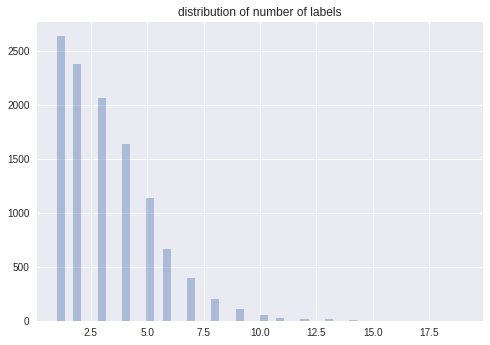

In [4]:
sns.distplot(label_counts, kde=False)
plt.title('distribution of number of labels')

## Now, lets have a look at the most common labels

First, we have a look at single labels, simply by counting all of the labels.

In [5]:
# define helper function to group data
def grouped_data_for(l):
    # wrap the grouped data into dataframe, since the inner is pd.Series, not what we need
    l_with_c = pd.DataFrame(
        pd.DataFrame({'label': l}).groupby('label').size().rename('n')
    ).sort_values('n', ascending=False).reset_index()
    return l_with_c

Show top 20 labels by occurence in the subsample of the training set available to kernels

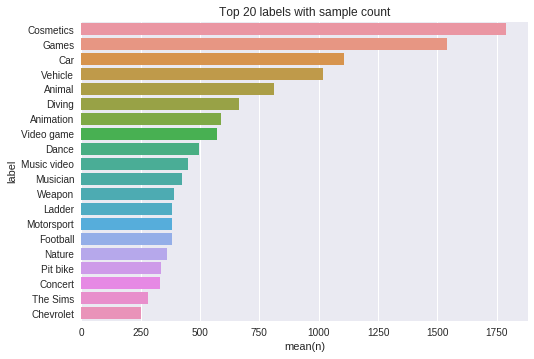

In [6]:
N = 20

textual_labels_with_counts_all = grouped_data_for(textual_labels)

sns.barplot(y='label', x='n', data=textual_labels_with_counts_all.iloc[0:N, :])
plt.title('Top {} labels with sample count'.format(N))

In [7]:
#singlets = [x for x in textual_labels_nested if len(x) == 1]
# flatten
#singlets = [item for sublist in singlets for item in sublist]
#N = 20
#textual_labels_with_counts = grouped_data_for(singlets)
#sns.barplot(y='label', x='n', data=textual_labels_with_counts.iloc[0:N, :])
#plt.title('Top {} labels with sample count from only samples with one label'.format(N))

Most common label combinations for 2-element label assignments

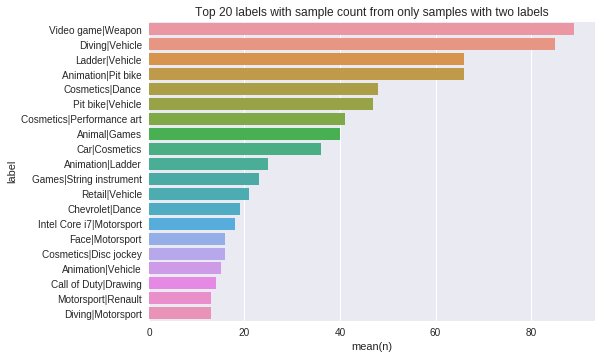

In [8]:
two_element_labels = ['|'.join(sorted(x)) for x in textual_labels_nested if len(x) == 2]

N = 20

textual_labels_with_counts = grouped_data_for(two_element_labels)

sns.barplot(y='label', x='n', data=textual_labels_with_counts.iloc[0:N, :])
plt.title('Top {} labels with sample count from only samples with two labels'.format(N))

For label triplets

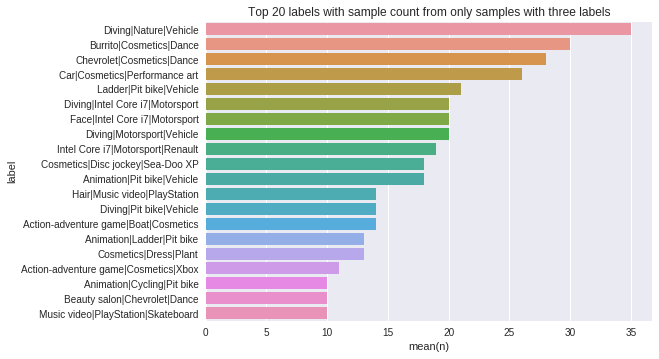

In [9]:
two_element_labels = ['|'.join(sorted(x)) for x in textual_labels_nested if len(x) == 3]

N = 20

textual_labels_with_counts = grouped_data_for(two_element_labels)

sns.barplot(y='label', x='n', data=textual_labels_with_counts.iloc[0:N, :])
plt.title('Top {} labels with sample count from only samples with three labels'.format(N))

## For each of the most occuring labels, how does the group size in average differ?

For this, we take the top 50 labels by count, and compute for each how many other labels are assigned to samples that also have the respective label from the top 50.

In [10]:
top_50_labels = list(textual_labels_with_counts_all['label'][0:50].values)
top_50_labels

['Cosmetics',
 'Games',
 'Car',
 'Vehicle',
 'Animal',
 'Diving',
 'Animation',
 'Video game',
 'Dance',
 'Music video',
 'Musician',
 'Weapon',
 'Ladder',
 'Motorsport',
 'Football',
 'Nature',
 'Pit bike',
 'Concert',
 'The Sims',
 'Chevrolet',
 'Transport',
 'Musical ensemble',
 'Intel Core i7',
 'String instrument',
 'Recipe',
 'Drums',
 'Stadium',
 'Cartoon',
 'Call of Duty: Ghosts',
 'Pet',
 'Outdoor recreation',
 'Food',
 'Orchestra',
 'Dragon Ball',
 'Guitar',
 'Performance art',
 'Racing',
 'Smartphone',
 'Race track',
 'Acoustic guitar',
 'Toy',
 'PlayStation',
 'Embroidery',
 'Model aircraft',
 'Call of Duty',
 'Winter sport',
 'Burrito',
 'Chihuahua',
 'Aircraft',
 'Call of Duty: Advanced Warfare']

In [11]:
label_group_counts = []
labels_for_group_counts = []
for label in top_50_labels:
    # this is a list of lists and
    # for each of the inner lists we want to know how many elements there are
    nested_labels_with_label = [x for x in textual_labels_nested if label in x]
    group_counts = [len(x) for x in nested_labels_with_label]
    label_group_counts = label_group_counts + group_counts
    labels_for_group_counts = labels_for_group_counts + [label]*len(group_counts)

count_df = pd.DataFrame({'label': labels_for_group_counts, 'group_size': label_group_counts})
count_df.head()

,group_size,label
0,3,Cosmetics
1,4,Cosmetics
2,4,Cosmetics
3,4,Cosmetics
4,3,Cosmetics


If we look at the extremes, we can see that for example if **Football** is in the labels of one example, you would find a higher count of accompanying labels when compared to samples that have **Food** label.

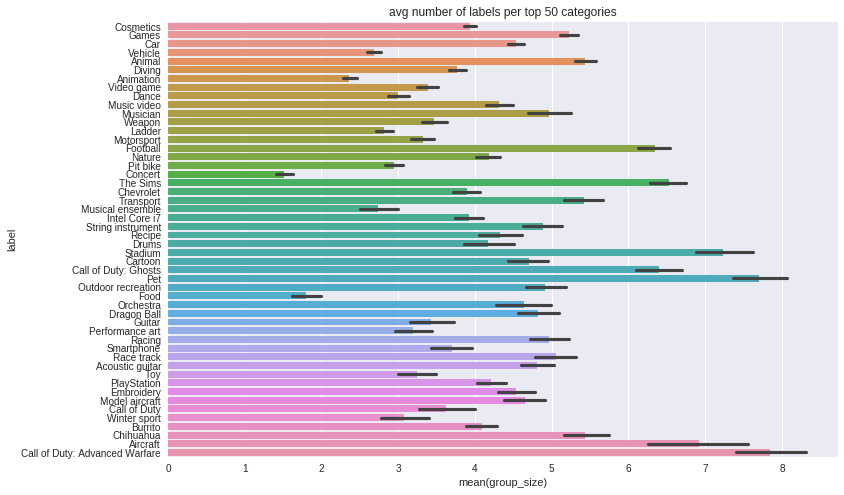

In [12]:
plt.figure(figsize=(12,8))
sns.barplot(y='label', x='group_size', data=count_df)
plt.title('avg number of labels per top 50 categories')

### Distributions of label counts split by a few top labels

Here we can see that, depending on the category, the group size distribution varies quite a lot. This information can be used to regularize the number of labels for a given video, e.g. if we are confident that the video is about **Vehicle** we can then constrain the number of additional labels for that sample to be within the distribution that we estimated from the training data.

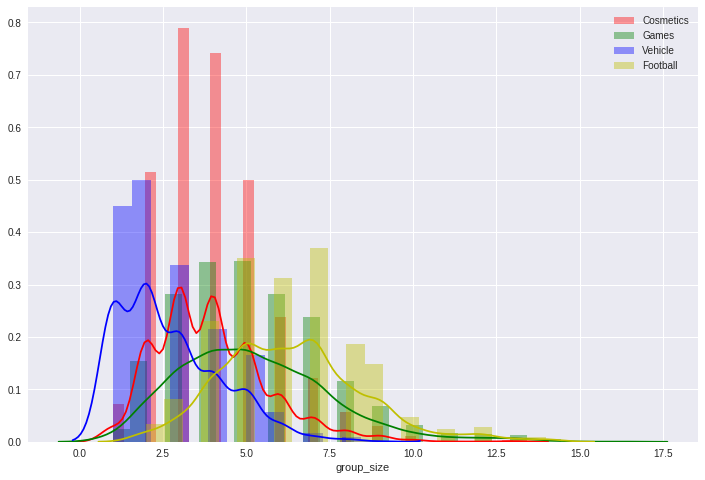

In [13]:
bins = [0, 1, 3, 14]
colors = ['r', 'g', 'b', 'y']

plt.figure(figsize=(12,8))
for bin, color in zip(bins, colors):
    sns.distplot(count_df[count_df['label'] == top_50_labels[bin]]['group_size'], kde=True, color=color)

plt.legend([top_50_labels[bin] for bin in bins])

### Estimate the probability of label occurence, given another label from training data

This probability can be interpreted as a similarity measure between labels.

In [14]:
K_labels = []

for i in top_50_labels:
    row = []
    for j in top_50_labels:
        # find all records that have label `i` in them
        i_occurs = [x for x in textual_labels_nested if i in x]
        # how often does j occur in total in them?
        j_and_i_occurs = [x for x in i_occurs if j in x]
        k = 1.0*len(j_and_i_occurs)/len(i_occurs)
        row.append(k)
    K_labels.append(row)

K_labels = np.array(K_labels)
K_labels = pd.DataFrame(K_labels)
K_labels.columns = top_50_labels
K_labels.index = top_50_labels

In [15]:
K_labels.head()

,Cosmetics,Games,Car,Vehicle,Animal,Diving,Animation,Video game,Dance,Music video,...,Toy,PlayStation,Embroidery,Model aircraft,Call of Duty,Winter sport,Burrito,Chihuahua,Aircraft,Call of Duty: Advanced Warfare
Cosmetics,1.000000,0.046901,0.476270,0.0,0.031267,0.000000,0.002233,0.036851,0.164712,0.005025,...,0.000000,0.002233,0.000000,0.000558,0.00000,0.004467,0.059743,0.007259,0.001117,0.0
Games,0.054545,1.000000,0.063636,0.0,0.524026,0.000649,0.000649,0.006494,0.001299,0.011688,...,0.000000,0.000649,0.000000,0.000000,0.00000,0.001948,0.000000,0.000649,0.074026,0.0
Car,0.771946,0.088688,1.000000,0.0,0.073303,0.000000,0.000905,0.042534,0.009050,0.000905,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.001810,0.013575,0.000905,0.0
Vehicle,0.000000,0.000000,0.000000,1.0,0.000000,0.394118,0.067647,0.000980,0.000980,0.000000,...,0.053922,0.000000,0.064706,0.040196,0.00098,0.007843,0.000000,0.000000,0.000000,0.0
Animal,0.068881,0.992620,0.099631,0.0,1.000000,0.000000,0.000000,0.004920,0.000000,0.002460,...,0.000000,0.001230,0.000000,0.000000,0.00000,0.000000,0.000000,0.001230,0.001230,0.0


The similarity matrix is not symmetric because observing label A given B is not the same as observing B given A.

For rows:

* football, the sims, call of duty, racing and race track

it intuitively makes sense to observe high likelihood of *games* label.

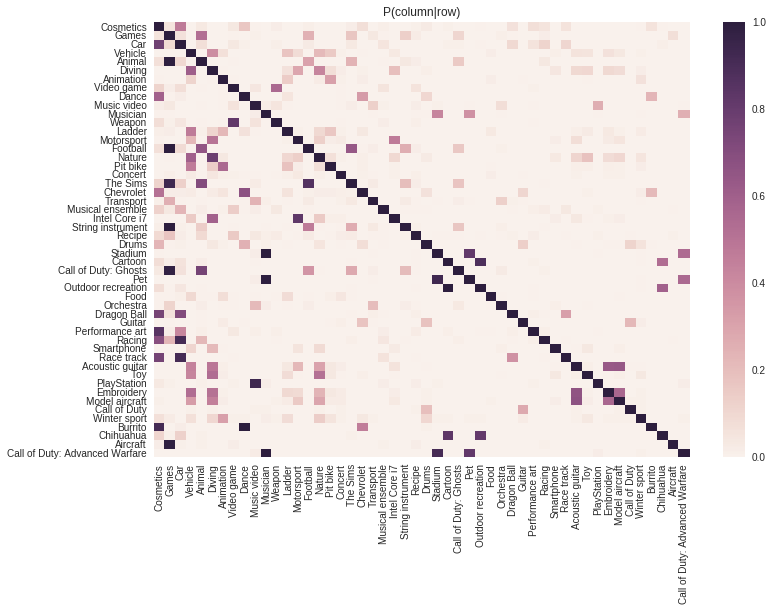

In [16]:
plt.figure(figsize=(12,8))
sns.heatmap(K_labels)
# probability of observing column label given row label
plt.title('P(column|row)')

****

# Video level RGB features

For this section I'll be going a little deeper in the video level RGB features, to get an idea about how they vary across different labels.
The basic idea is to compare the distributions of the averaged video level features. To do this, we are going to take the average of the video level RGB features, which is a very compressed format of that feature and compare the distribution of these values across top labels.

In [17]:
filenames = ["../input/video_level/train-{}.tfrecord".format(i) for i in range(10)]

cosmetics = []
games = []
car = []
vehicle = []
animal = []

for filename in filenames:
    for example in tf.python_io.tf_record_iterator(filename):
        tf_example = tf.train.Example.FromString(example)
        label_example = list(tf_example.features.feature['labels'].int64_list.value)
        label_example_textual = list(labels_df[labels_df['label_id'].isin(label_example)]['label_name'])
        mean_mean_rgb = np.mean(tf_example.features.feature['mean_rgb'].float_list.value)
        for label in label_example_textual:
            if label == 'Cosmetics':
                cosmetics.append(mean_mean_rgb)
            elif label == 'Games':
                games.append(mean_mean_rgb)
            elif label == 'Car':
                car.append(mean_mean_rgb)
            elif label == 'Vehicle':
                vehicle.append(mean_mean_rgb)
            elif label == 'Animal':
                animal.append(mean_mean_rgb)


/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:12: DeprecationWarning: PyUnicode_AsEncodedObject() is deprecated; use PyUnicode_AsEncodedString() to encode from str to bytes or PyCodec_Encode() for generic encoding
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:14: DeprecationWarning: PyUnicode_AsEncodedObject() is deprecated; use PyUnicode_AsEncodedString() to encode from str to bytes or PyCodec_Encode() for generic encoding


In [18]:
len(cosmetics), len(games), len(car), len(vehicle), len(animal)

(1791, 1540, 1105, 1020, 813)

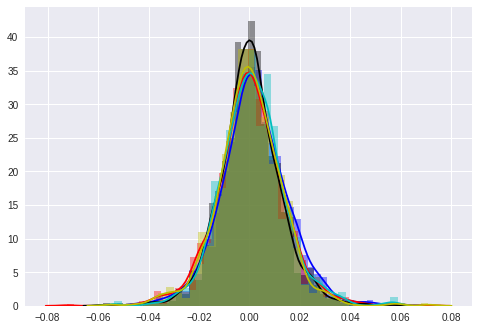

In [19]:
sns.distplot(cosmetics, color='b')
sns.distplot(games, color='r')
sns.distplot(car, color='k')
sns.distplot(vehicle, color='c')
sns.distplot(animal, color='y')

As expected the distributions don't differ a lot by just looking at them. You could now do a one way ANOVA test to find out whether the mean of any pair of these groups differ significantly, but let's not do that now.

----------


# Frame level features

For this section, we are going to have a detailed look at the audio frame level features of a few selected videos.
The frame level features, audio and video, were extracted by taking a sample each second uniformly across the whole video.

See [this][1] forum post for details.


  [1]: https://www.kaggle.com/c/youtube8m/discussion/28848#162409

In [20]:
frame_lvl_record = "../input/frame_level/train-1.tfrecord"

def rgb_and_audio_from(tf_seq_example):
    feat_rgb = []
    feat_audio = []
    n_frames = len(tf_seq_example.feature_lists.feature_list['audio'].feature)
    sess = tf.InteractiveSession()
    rgb_frame = []
    audio_frame = []
    # iterate through frames for that example
    for i in range(n_frames):
        rgb_frame.append(tf.cast(tf.decode_raw(
                tf_seq_example.feature_lists.feature_list['rgb'].feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
        audio_frame.append(tf.cast(tf.decode_raw(
                tf_seq_example.feature_lists.feature_list['audio'].feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
        
        
    sess.close()
    feat_rgb.append(rgb_frame)
    feat_audio.append(audio_frame)
    return feat_rgb, feat_audio

# now, let's read the frame-level data
# due to execution time, we're only going to read the first video

i = 0
for example in tf.python_io.tf_record_iterator(frame_lvl_record):     
#    i+=1
#    if i < 3:
#        continue
    tf_seq_example = tf.train.SequenceExample.FromString(example)
    video_id = tf_seq_example.context.feature['video_id'].bytes_list.value[0]
    print('https://www.youtube.com/watch?v={}'.format(str(video_id)))
    rgb, audio = rgb_and_audio_from(tf_seq_example)
    break

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:34: DeprecationWarning: PyUnicode_AsEncodedObject() is deprecated; use PyUnicode_AsEncodedString() to encode from str to bytes or PyCodec_Encode() for generic encoding
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: PyUnicode_AsEncodedObject() is deprecated; use PyUnicode_AsEncodedString() to encode from str to bytes or PyCodec_Encode() for generic encoding
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:13: DeprecationWarning: PyUnicode_AsEncodedObject() is deprecated; use PyUnicode_AsEncodedString() to encode from str to bytes or PyCodec_Encode() for generic encoding
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:16: DeprecationWarning: PyUnicode_AsEncodedObject() is deprecated; use PyUnicode_AsEncodedString() to encode from str to bytes or PyCodec_Encode() for generic encoding


https://www.youtube.com/watch?v=b'-1VnJGJ6c2U'


In [21]:
#YouTubeVideo('-1xYbUNeA7U')

In [22]:
audio = np.array(audio).squeeze()
# audio now in (128, 168)
audio = np.transpose(audio, (1, 0))
print(audio.shape)

(128, 161)


So we have a two-dimensional array for the audio frame level feature of one video. Each feature has a dimensionality of **128**, so the video is 161 seconds long.
As it says in the post above, both audio and video frame level features were transformed with a fixed point PCA. However for illustration I'll just consider each of the 161 audio features as a 128-point FFT, now let's see if there is some structure once we have reshaped it and plotted it.

We can then interpret this reshaped data as a [spectrogram][1], very frequently used in digital audio signal processing, where each row corresponds to a specific frequency, each column to a timestep (for us 1 second) and the color of each of the cells to the magnitude of the audio frequency in that frequency bin.


  [1]: https://en.wikipedia.org/wiki/Spectrogram

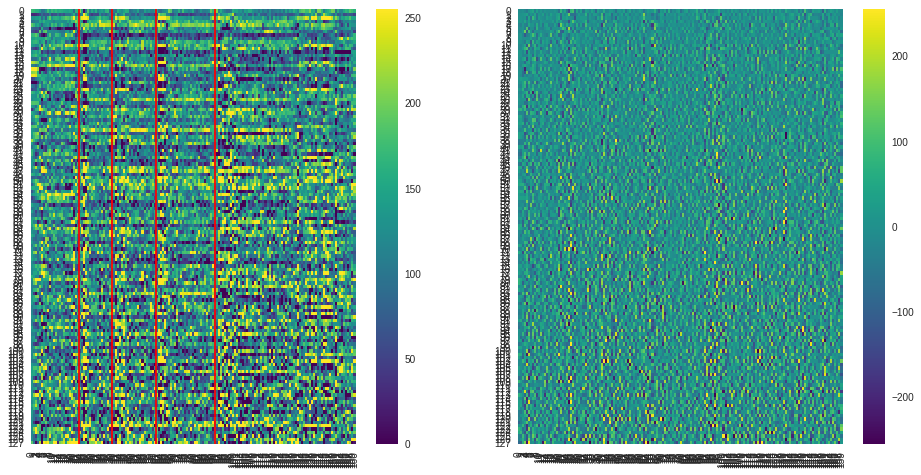

In [23]:
cmap = plt.get_cmap('viridis') # plasma
# let's also look at the first order diff across time
daudio = np.diff(audio, axis=1)
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.heatmap(audio, cmap=cmap)
plt.axvline(x=24, ymin=0, ymax=128, color='r')
plt.axvline(x=40, ymin=0, ymax=128, color='r')
plt.axvline(x=62, ymin=0, ymax=128, color='r')
plt.axvline(x=91, ymin=0, ymax=128, color='r')
plt.subplot(122)
sns.heatmap(daudio, cmap=cmap)

You can see vertical lines of audio segments over time, they are also visible in the first order difference. I've also marked the beginnings with red lines. Can we still make these out when averaging over the 128 dimensions?

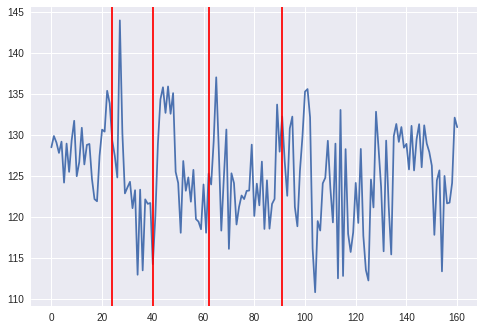

In [24]:
plt.figure()
plt.plot(audio.mean(axis=0))
# plot the same indicator lines
plt.axvline(x=24, ymin=0, ymax=200, color='r')
plt.axvline(x=40, ymin=0, ymax=200, color='r')
plt.axvline(x=62, ymin=0, ymax=200, color='r')
plt.axvline(x=91, ymin=0, ymax=200, color='r')